In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torchviz import make_dot

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [140]:
# Hyper-parameters initialization

IMAGE_HEIGHT=28
IMAGE_WIDTH=28
IMAGE_SIZE = IMAGE_WIDTH*IMAGE_HEIGHT
NUM_CLASSES = 10
MAX_EPOCH = 5
BATCH_SIZE = 120
LEARNING_RATE = 0.01

KERNEL_SIZE=5

INPUT [BATCH_SIZE,CHANNELS,WIDTH,HEIGHT](e.g. [120,1,28,28] ): will hold the raw pixel values of the images in the batch, in this case an image of width 28, height 28, and with gray scale color.

CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [16,28 - kernelsize - 1, 28 -kernelsize - 1] [BATCH_SIZE,16,24,24] if we decided to use 16 filters.

RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([BATCH_SIZE,16,24,24]).

POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [BATCH_SIZE,16,12,12].

FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [BATCH_SIZE,1,10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

$$W_{out} = \left\lfloor\frac{W_{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

In [149]:
test_x = torch.empty(BATCH_SIZE,1,IMAGE_WIDTH, IMAGE_HEIGHT).uniform_(0, 1) 
print(test_x.shape)
conv2d = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=KERNEL_SIZE,bias=True)
conv2d_result1 = conv2d(test_x)
print(conv2d_result1.shape)
relu1_result = F.relu(conv2d_result1)
print(relu1_result.shape)

print(F.max_pool2d(input=relu1_result,kernel_size=2).shape)




torch.Size([120, 1, 28, 28])
torch.Size([120, 16, 24, 24])
torch.Size([120, 16, 24, 24])
torch.Size([120, 16, 12, 12])


$$ W_{in} = 28$$
Assuming padding =1 and stride=1,then: $$kernel\_size - 1 = (5-1)$$
$$ W_{out} = W_{in} - kernel\_size - 1 = 24$$
$$ W_{out} = 28 -4 = 24$$

In [27]:
max_pool1 = nn.MaxPool2d(kernel_size=(2,2))
print(relu1_result.shape)
max_pool1_result = max_pool1(relu1_result)

print(max_pool1_result.shape)
max_pool1_result = max_pool1_result.view(BATCH_SIZE,-1)
print(max_pool1_result.shape)

linear_fc1 = nn.Linear(in_features=max_pool1_result.shape[1],out_features=NUM_CLASSES)
linear_fc1_result = linear_fc1(max_pool1_result)
print(linear_fc1_result.shape)


torch.Size([60, 6, 19, 19])
torch.Size([60, 6, 9, 9])
torch.Size([60, 486])
torch.Size([60, 10])


In [131]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=KERNEL_SIZE,bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #it is recommended to put the FC layer here in the init function instead of in forward function
        self.linear_fc = nn.Linear(in_features=12*12*16,out_features=NUM_CLASSES)
                
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0),-1)
        x = self.linear_fc(x)
        return x



In [112]:

class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10,bias=True)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [55]:
#Download Fashion-MNIST dataset
ROOT = "data/"

#transforms.ToTensor() transforms the PIL.Image.Image format to pytorch Tensor 

train_Fashion_MINST = FashionMNIST(ROOT+"Fashion-MNIST", train=True, download=True,transform=transforms.ToTensor())
test_Fashion_MINST = FashionMNIST(ROOT+"Fashion-MNIST", train=False, download=True,transform=transforms.ToTensor())


train_data_loader = torch.utils.data.DataLoader(train_Fashion_MINST,batch_size=BATCH_SIZE,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_Fashion_MINST,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)


In [56]:
#Before iterating all the training set, verfiy the dimensions of the training and target tensors of a random example
(images, labels) = list(train_data_loader)[0]
# images shape now is [BATCH_SIZE, 1, 28, 28], it should be reshaped ot [BATCH_SIZE,IMAGE_SIZE]
images = images.reshape(BATCH_SIZE,-1) # it is the same of images = images.reshape(-1,IMAGE_SIZE)
print(images.shape)
print(labels.shape)
assert images.shape[0] == BATCH_SIZE
print(images.shape)
print(IMAGE_SIZE)
assert images.shape[1] == IMAGE_SIZE
assert labels.shape[0] == BATCH_SIZE


torch.Size([120, 784])
torch.Size([120])
torch.Size([120, 784])
784


In [141]:
nn_model = NeuralNetwork()
#nn_model = CNN(NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(nn_model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.RMSprop(nn_model.parameters(), lr=LEARNING_RATE)

for epoch in range(0,MAX_EPOCH):
    
    running_loss = 0
    #train_data_loader is already partitioned to multiple batches, each batch with size = LENGTH(TRAINING_SET)/BATCH_SIZE
    for batch_index, (images, labels) in enumerate(train_data_loader):
        images = Variable(images.reshape(-1,1, IMAGE_WIDTH,IMAGE_HEIGHT),requires_grad=True)
        labels = Variable(labels)

        #reset the gradients to zero
        optimizer.zero_grad()
        
        #calculate predictions (y^)

        predictions = nn_model(images)

        #calculate Cross Entropy loss between labels(y) and predictions(y^)
        loss = criterion(predictions, labels)

        #Backward propagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (batch_index + 1) % 300 == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch, batch_index + 1, running_loss / BATCH_SIZE))
            running_loss = 0.0

[0,   300] loss: 1.676
[1,   300] loss: 0.934
[2,   300] loss: 0.816
[3,   300] loss: 0.772
[4,   300] loss: 0.743


In [142]:
# Test the model accuracy
correct_instances = 0
total_test_examples = 0
for images, labels in test_data_loader:
    images = Variable(images.reshape(-1, 1, IMAGE_WIDTH,IMAGE_HEIGHT))
    predictions_output = nn_model(images)
    _, predicted_classes = torch.max(predictions_output.data, 1)
    total_test_examples = total_test_examples + len(images)
    correct_instances = correct_instances + (predicted_classes == labels).sum()

print('Number of correct classified test images: %d %%' % (100 * correct_instances / total_test_examples))

Number of correct classified test images: 87 %


In [143]:
classes_names = {}
classes_names[0] = 'T-shirt/top'
classes_names[1] = 'Trouser'
classes_names[2] = 'Pullover'
classes_names[3] = 'Dress'
classes_names[4] = 'Coat'
classes_names[5] = 'Sandal'
classes_names[6] = 'Shirt'
classes_names[7] = 'Sneaker'
classes_names[8] = 'Bag'
classes_names[9] = 'Ankle boot'


In [144]:
def visualize_model(lr_model,dataloaders, num_images=12):
    was_training = lr_model.training
    lr_model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad(): # to freeze the weights of the model ... we need only visualize the predictions.
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.reshape(-1,1,IMAGE_WIDTH,IMAGE_HEIGHT)
            outputs = lr_model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('{}'.format(classes_names[int(preds[j])]))
                plt.subplots_adjust(hspace=0.6,wspace=0.6,)
                plt.imshow(inputs.reshape(-1,28,28).data[j])

                if images_so_far == num_images:
                    lr_model.train(mode=was_training)
                    return
        lr_model.train(mode=was_training)

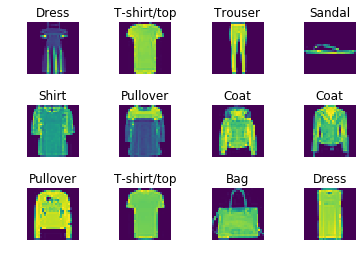

In [145]:
visualize_model(nn_model,train_data_loader)

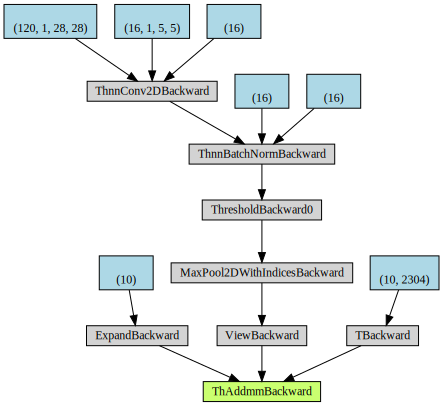

In [146]:
make_dot(predictions)